In [1]:
import datetime
import itertools
import os
import pathlib
import sklearn

import numpy as np
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns
import scipy.stats as stats

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.base import BaseEstimator, TransformerMixin

In [2]:
## from: https://www2.1010data.com/documentationcenter/prod/Tutorials/MachineLearningExamples/CensusIncomeDataSet.html
header_names = [
    'age',
    'class_worker',
    'det_ind_code',
    'det_occ_code',
    'education',
    'wage_per_hour',
    'hs_college',
    'marital_stat',
    'major_ind_code',
    'major_occ_code',
    'race',
    'hisp_origin',
    'sex',
    'union_member',
    'unemp_reason',
    'full_or_part_emp',
    'capital_gains',
    'capital_losses',
    'stock_dividends',
    'tax_filer_stat',
    'region_prev_res',
    'state_prev_res',
    'det_hh_fam_stat',
    'det_hh_summ',
    'instance_weight', ## this field is not used as a feature
    'mig_chg_msa',
    'mig_chg_reg',
    'mig_move_reg',
    'mig_same',
    'mig_prev_sunbelt',
    'num_emp',
    'fam_under_18',
    'country_father',
    'country_mother',
    'country_self',
    'citizenship',
    'own_or_self',
    'vet_question',
    'vet_benefits',
    'weeks_worked',
    'year',
    'income_50k',
]

data_dir = os.path.join(pathlib.Path(os.getcwd()).parent, 'data')
df = pd.read_csv(os.path.join(data_dir, 'census-income.data.csv'), header=None, names=header_names)
df_test = pd.read_csv(os.path.join(data_dir, 'census-income.test.csv'), header=None, names=header_names)
df = pd.concat([df,df_test]) ## the test file is also labelled so they can be merged
df = df.drop(columns=['instance_weight']) ## not used for our analysis

categorical_features = [
    'class_worker',
    'det_ind_code',
    'det_occ_code',
    'education',
    'hs_college',
    'marital_stat',
    'major_ind_code',
    'major_occ_code',
    'race',
    'hisp_origin',
    'sex',
    'union_member',
    'unemp_reason',
    'full_or_part_emp',
    'tax_filer_stat',
    'region_prev_res',
    'state_prev_res',
    'det_hh_fam_stat',
    'det_hh_summ',
    'mig_chg_msa',
    'mig_chg_reg',
    'mig_move_reg',
    'mig_same',
    'mig_prev_sunbelt',
    'fam_under_18',
    'country_father',
    'country_mother',
    'country_self',
    'citizenship',
    'own_or_self',
    'vet_question',
    'vet_benefits',
    'year',
]
df[categorical_features] = df[categorical_features].astype('category')

In [3]:
### Drop columns not used in modelling
df = df.drop(
    columns=[
        'region_prev_res',
        'state_prev_res',
        'det_hh_fam_stat',
        'det_hh_summ',
        'mig_chg_msa',
        'mig_chg_reg',
        'mig_move_reg',
        'mig_same',
        'mig_prev_sunbelt',
        'country_father',
        'country_mother',
        'country_self',
        'year',
    ]
)


In [4]:
## test set for feature selection
small_df = df.sample(frac = .005)

In [11]:
def preprocess_pipeline(numeric_features, categorical_features):
    ### Scale numerical, one hot categorical

    numeric_transformer = Pipeline(
        steps=[
            #('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler()),
        ]
    )
    categorical_transformer = Pipeline(
        steps=[
            #('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore')),
        ]
    )
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)]
    )
    preprocess_pipe = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
        ]
    )
    
    return preprocess_pipe

In [12]:
### Preprocess the data
target = 'income_50k'
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
categorical_features = df.select_dtypes(include=['object','bool', 'category']).drop([target], axis=1).columns
X = small_df.drop(target, axis=1)
y = small_df[target]
preprocessor = preprocess_pipeline(numeric_features, categorical_features)
X_preprocessed = preprocessor.fit_transform(X)

In [40]:
### Make a list of all the columns after one hot encoding
ohe = preprocessor['preprocessor'].named_transformers_['cat']['onehot']
cat_processed = ohe.get_feature_names(X[categorical_features].columns)
all_processed_cols = np.concatenate((numeric_features, cat_processed), axis=0)
all_processed_cols

array(['age', 'wage_per_hour', 'capital_gains', 'capital_losses',
       'stock_dividends', 'num_emp', 'weeks_worked',
       'class_worker_ Federal government',
       'class_worker_ Local government', 'class_worker_ Never worked',
       'class_worker_ Not in universe', 'class_worker_ Private',
       'class_worker_ Self-employed-incorporated',
       'class_worker_ Self-employed-not incorporated',
       'class_worker_ State government', 'class_worker_ Without pay',
       'det_ind_code_0', 'det_ind_code_1', 'det_ind_code_2',
       'det_ind_code_3', 'det_ind_code_4', 'det_ind_code_5',
       'det_ind_code_6', 'det_ind_code_7', 'det_ind_code_8',
       'det_ind_code_9', 'det_ind_code_11', 'det_ind_code_12',
       'det_ind_code_13', 'det_ind_code_15', 'det_ind_code_16',
       'det_ind_code_17', 'det_ind_code_18', 'det_ind_code_19',
       'det_ind_code_20', 'det_ind_code_21', 'det_ind_code_22',
       'det_ind_code_23', 'det_ind_code_24', 'det_ind_code_25',
       'det_ind_code_27'

Optimal number of features : 117


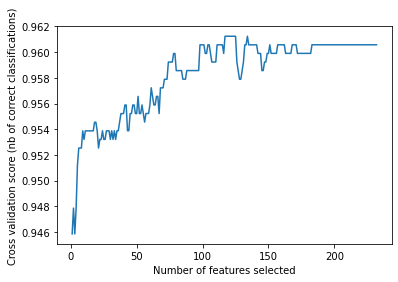

In [41]:
### RFE CV to find best features 
clf = LogisticRegression(n_jobs=-1)
rfecv = RFECV(clf, step=1, cv=5)
rfecv.fit(X_preprocessed, y)
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [45]:
### Show all selected features
selected_features = all_processed_cols[rfecv.support_]

array(['age', 'capital_gains', 'weeks_worked',
       'class_worker_ Local government',
       'class_worker_ Self-employed-incorporated',
       'class_worker_ Self-employed-not incorporated', 'det_ind_code_3',
       'det_ind_code_4', 'det_ind_code_8', 'det_ind_code_9',
       'det_ind_code_11', 'det_ind_code_12', 'det_ind_code_13',
       'det_ind_code_19', 'det_ind_code_22', 'det_ind_code_24',
       'det_ind_code_25', 'det_ind_code_30', 'det_ind_code_31',
       'det_ind_code_32', 'det_ind_code_33', 'det_ind_code_34',
       'det_ind_code_35', 'det_ind_code_37', 'det_ind_code_38',
       'det_ind_code_39', 'det_ind_code_40', 'det_ind_code_43',
       'det_ind_code_45', 'det_ind_code_49', 'det_ind_code_50',
       'det_occ_code_2', 'det_occ_code_3', 'det_occ_code_4',
       'det_occ_code_5', 'det_occ_code_6', 'det_occ_code_7',
       'det_occ_code_9', 'det_occ_code_12', 'det_occ_code_13',
       'det_occ_code_14', 'det_occ_code_16', 'det_occ_code_19',
       'det_occ_code_21', 'det